# VAE Training with desisky Package

This notebook demonstrates how to train a Variational Autoencoder (VAE) on DESI sky spectra using the built-in training utilities in the `desisky` package.

The VAE uses the **InfoVAE-MMD objective** which provides better control over reconstruction quality vs. latent space regularization compared to standard β-VAE.

## What's New

This notebook uses the new **production-ready training infrastructure** from `desisky.training`:
- `VAETrainer`: Complete training loop with checkpointing
- `VAETrainingConfig`: Easy configuration with sensible defaults
- `vae_loss_infovae`: InfoVAE-MMD loss function
- Automatic best model tracking and saving
- Comprehensive training history tracking

See the original notebook `04_vae_training.ipynb` for the low-level implementation details.

## Imports

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split

# Import desisky components
from desisky.data import SkySpecVAC
from desisky.models.vae import make_SkyVAE
from desisky.training import (
    VAETrainer,
    VAETrainingConfig,
    NumpyLoader,
)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

JAX version: 0.7.1
JAX devices: [CudaDevice(id=1)]


2025-11-13 13:05:46.660514: W external/xla/xla/service/platform_util.cc:220] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


## Load Data

Load the DESI sky spectra Value-Added Catalog (VAC).

In [2]:
# Load the sky spectra value-added catalog
vac = SkySpecVAC(version='v1.0', download=True)
wavelength, flux, metadata = vac.load()

print(f"Loaded {flux.shape[0]:,} sky spectra")
print(f"Wavelength range: {wavelength.min():.1f} - {wavelength.max():.1f} Å")
print(f"Spectrum shape: {flux.shape}")

Loaded 9,176 sky spectra
Wavelength range: 3600.0 - 9824.0 Å
Spectrum shape: (9176, 7781)


## Create Train/Test Split and Data Loaders

In [3]:
# Ensure flux is float32 for JAX
flux = flux.astype(np.float32)

# Create 90/10 train/test split
dataset_size = len(flux)
train_size = int(0.9 * dataset_size)
test_size = dataset_size - train_size

flux_tensor = torch.from_numpy(flux)
generator = torch.Generator().manual_seed(32)
train_set, test_set = random_split(flux_tensor, [train_size, test_size], generator=generator)

# Create data loaders
batch_size = 64
train_loader = NumpyLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = NumpyLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

print(f"Training set: {len(train_set):,} spectra ({len(train_loader)} batches)")
print(f"Test set: {len(test_set):,} spectra ({len(test_loader)} batches)")

Training set: 8,258 spectra (130 batches)
Test set: 918 spectra (15 batches)


## Initialize VAE Model

In [4]:
# Model architecture
in_channels = flux.shape[1]  # 7781 for DESI
latent_dim = 8  # Low-dimensional latent space

model = make_SkyVAE(in_channels=in_channels, latent_dim=latent_dim, key=jr.PRNGKey(42))

print(f"VAE Architecture:")
print(f"  Input channels: {in_channels}")
print(f"  Latent dimension: {latent_dim}")
print(f"  Compression ratio: {in_channels / latent_dim:.1f}x")

VAE Architecture:
  Input channels: 7781
  Latent dimension: 8
  Compression ratio: 972.6x


## Configure and Train

The `VAETrainingConfig` provides a clean interface to all training hyperparameters.

### InfoVAE Hyperparameters:

- **beta** (β): Weight for KL divergence. Lower values (e.g., 1e-3) prioritize reconstruction quality.
- **lam** (λ): Total latent regularization weight. Typical range: 1.0 to 10.0.
- **kernel_sigma**: RBF kernel bandwidth for MMD. Set to `"auto"` for automatic computation.

The loss function is:
```
L = Reconstruction + β·KL + (λ-β)·MMD
```

In [5]:
# Configure training
config = VAETrainingConfig(
    epochs=100,
    learning_rate=1e-4,
    beta=1e-3,          # KL weight (same as original notebook)
    lam=4.0,            # Total regularization weight
    kernel_sigma="auto",
    save_best=True,
    run_name="sky_vae_demo",
    print_every=10,
    random_seed=42,
)

# Create trainer and train
trainer = VAETrainer(model, config)

print("Starting training...\n")
trained_model, history = trainer.train(train_loader, test_loader)

print(f"\n✓ Training complete!")
print(f"  Best test loss: {history.best_test_loss:.6f} (epoch {history.best_epoch})")
print(f"  Final reconstruction MSE: {history.test_recon[-1]:.6f}")

Starting training...

Epoch    0/100 | Train: 4115065.742625 (R:4115065.6314 KL:0.0084 MMD:0.1053) | Test: 21.060044 (R:20.9364) | Best: 21.060044
Epoch   10/100 | Train: 7.670288 (R:7.5265 KL:0.0163 MMD:0.1275) | Test: 7.492352 (R:7.3439) | Best: 7.492352
Epoch   20/100 | Train: 7.527906 (R:7.3782 KL:0.0205 MMD:0.1292) | Test: 7.247389 (R:7.0897) | Best: 7.247389
Epoch   30/100 | Train: 3.753619 (R:3.5678 KL:0.0517 MMD:0.1341) | Test: 3.910885 (R:3.7212) | Best: 3.910885
Epoch   40/100 | Train: 3.550827 (R:3.3898 KL:0.0293 MMD:0.1318) | Test: 3.760470 (R:3.5954) | Best: 3.757709
Epoch   50/100 | Train: 3.467243 (R:3.3162 KL:0.0208 MMD:0.1303) | Test: 3.683915 (R:3.5289) | Best: 3.683915
Epoch   60/100 | Train: 3.423110 (R:3.2771 KL:0.0164 MMD:0.1296) | Test: 3.655752 (R:3.5051) | Best: 3.649631
Epoch   70/100 | Train: 3.419018 (R:3.2745 KL:0.0155 MMD:0.1290) | Test: 3.646168 (R:3.4968) | Best: 3.631805
Epoch   80/100 | Train: 1.064936 (R:0.8956 KL:0.0399 MMD:0.1295) | Test: 1.058987 (

## Visualize Training History

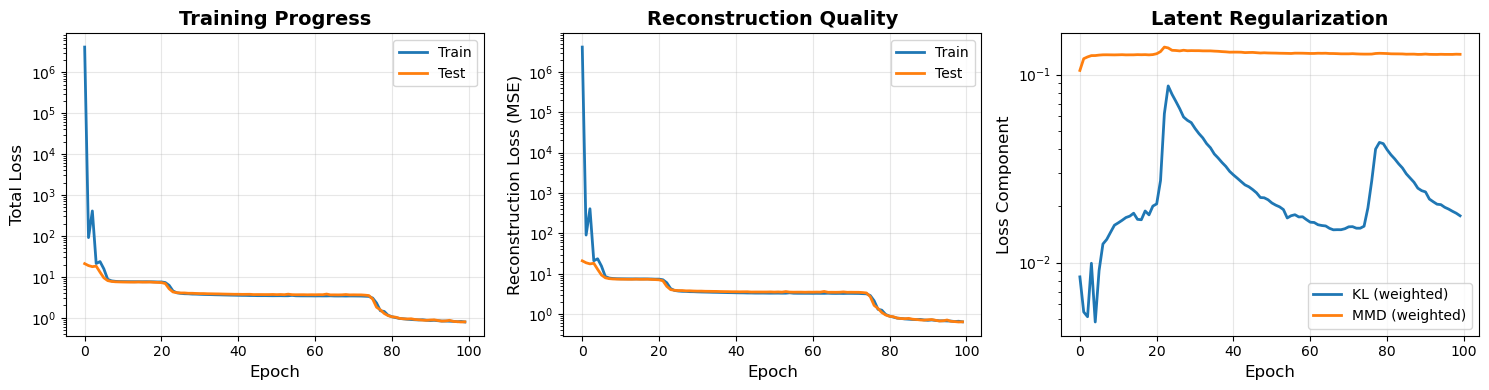

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Total Loss
ax = axes[0]
ax.plot(history.train_losses, label='Train', linewidth=2)
ax.plot(history.test_losses, label='Test', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Total Loss', fontsize=12)
ax.set_title('Training Progress', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 2: Reconstruction Loss
ax = axes[1]
ax.plot(history.train_recon, label='Train', linewidth=2)
ax.plot(history.test_recon, label='Test', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Reconstruction Loss (MSE)', fontsize=12)
ax.set_title('Reconstruction Quality', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 3: Latent Space Regularization
ax = axes[2]
ax.plot(history.train_kl, label='KL (weighted)', linewidth=2)
ax.plot(history.train_mmd, label='MMD (weighted)', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss Component', fontsize=12)
ax.set_title('Latent Regularization', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Test Reconstruction

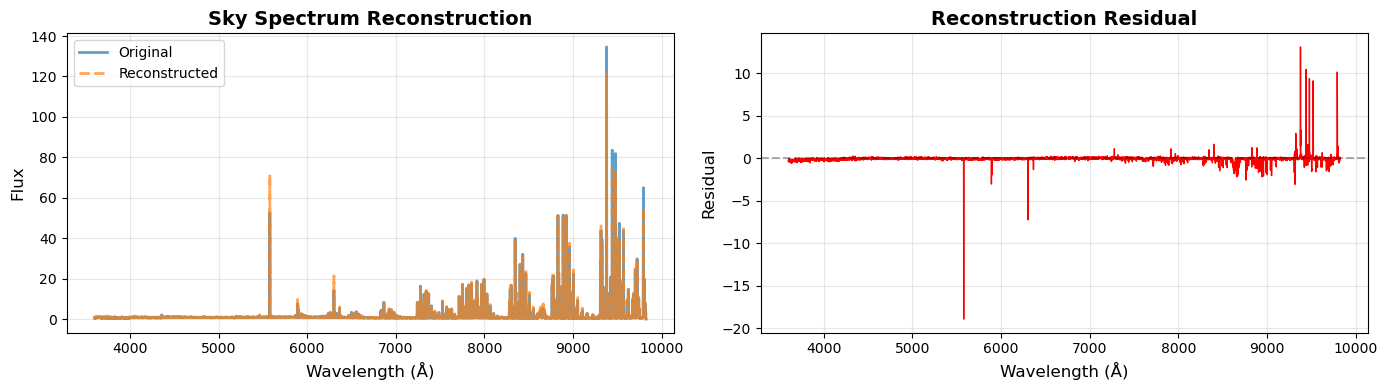

Reconstruction MSE: 0.225470


In [7]:
# Get a test sample and reconstruct it
test_sample = flux[train_size:train_size+1]
result = trained_model(jnp.array(test_sample), jr.PRNGKey(0))
reconstructed = np.array(result['output'][0])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Original vs Reconstructed
ax = axes[0]
ax.plot(wavelength, test_sample[0], label='Original', linewidth=2, alpha=0.7)
ax.plot(wavelength, reconstructed, label='Reconstructed', linewidth=2, alpha=0.7, linestyle='--')
ax.set_xlabel('Wavelength (Å)', fontsize=12)
ax.set_ylabel('Flux', fontsize=12)
ax.set_title('Sky Spectrum Reconstruction', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Residual
ax = axes[1]
residual = test_sample[0] - reconstructed
ax.plot(wavelength, residual, linewidth=1, color='red')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Wavelength (Å)', fontsize=12)
ax.set_ylabel('Residual', fontsize=12)
ax.set_title('Reconstruction Residual', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mse = np.mean((test_sample[0] - reconstructed) ** 2)
print(f"Reconstruction MSE: {mse:.6f}")

## Save and Load Model

The best model was automatically saved during training. Here's how to load it back.

In [8]:
from desisky.io import load
from pathlib import Path

# Model was saved to ~/.cache/desisky/saved_models/vae/sky_vae_demo.eqx
save_path = Path.home() / ".cache" / "desisky" / "saved_models" / "vae" / "sky_vae_demo.eqx"

if save_path.exists():
    # Load the model - need to pass the constructor function
    loaded_model, metadata = load(save_path, constructor=make_SkyVAE)
    
    print("✓ Model loaded successfully!")
    print(f"\nModel Architecture:")
    print(f"  Input channels: {metadata['arch']['in_channels']}")
    print(f"  Latent dimension: {metadata['arch']['latent_dim']}")
    
    print(f"\nTraining Info:")
    print(f"  Date: {metadata['training']['date']}")
    print(f"  Best epoch: {metadata['training']['epoch']}")
    print(f"  Test loss: {metadata['training']['test_loss']:.6f}")
    print(f"  Reconstruction MSE: {metadata['training']['test_metrics']['recon']:.6f}")
    
    print(f"\nHyperparameters:")
    print(f"  Beta: {metadata['training']['config']['beta']}")
    print(f"  Lambda: {metadata['training']['config']['lam']}")
    print(f"  Learning rate: {metadata['training']['config']['learning_rate']}")
    
    # Test the loaded model
    test_result = loaded_model(jnp.array(test_sample), jr.PRNGKey(0))
    print(f"\n✓ Loaded model works! Output shape: {test_result['output'].shape}")
else:
    print(f"Model not found at {save_path}")

✓ Model loaded successfully!

Model Architecture:
  Input channels: 7781
  Latent dimension: 8

Training Info:
  Date: 2025-11-13T13:07:38.746040
  Best epoch: 98
  Test loss: 0.791551
  Reconstruction MSE: 0.641125

Hyperparameters:
  Beta: 0.001
  Lambda: 4.0
  Learning rate: 0.0001

✓ Loaded model works! Output shape: (1, 7781)


## Summary

This notebook demonstrated:

1. ✅ **Training**: Simple 3-line training with `VAETrainer` and `VAETrainingConfig`
2. ✅ **Monitoring**: Automatic tracking of all loss components (reconstruction, KL, MMD)
3. ✅ **Visualization**: Training curves showing convergence
4. ✅ **Testing**: Example reconstruction on test data
5. ✅ **Persistence**: Automatic checkpoint saving and loading with metadata

### Next Steps

- See `03_vae_analysis.ipynb` for detailed latent space analysis and interpolation
- See `docs/VAE_TRAINING.md` for complete API documentation
- Experiment with different hyperparameters (beta, lambda, latent_dim)
- Use the trained VAE as part of a Latent Diffusion Model